<a href="https://colab.research.google.com/github/Aimantech/ml-test/blob/master/recognision.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install imgaug

    100% |████████████████████████████████| 634kB 15.3MB/s 
  Running setup.py bdist_wheel for imgaug ... - \ done
  Stored in directory: /root/.cache/pip/wheels/97/ec/48/0d25896c417b715af6236dbcef8f0bed136a1a5e52972fc6d0
Successfully built imgaug


In [7]:
os.getcwd()

'/content/mltest'

In [139]:
from google.colab import files
files.upload() 

Saving img.zip to img (1).zip


In [0]:
import zipfile
zipobject=zipfile.ZipFile('/content/data/img (1).zip')
zipobject.extractall() 

In [128]:
from google.colab import files
files.upload() 

Saving model1_better.h5 to model1_better.h5


In [20]:
ls

KL01AA1245.json  KL01AJ2330.json  KL01AY4317.json  KL01BM3602.json
KL01AA1246.json  KL01AJ2331.json  KL01AY4318.json  KL01BM3603.json
KL01AA1247.json  KL01AJ2332.json  KL01AY4319.json  KL01BM3604.json
KL01AA1248.json  KL01AJ2333.json  KL01AY4320.json  KL01BM3605.json
KL01AA1249.json  KL01AJ2334.json  KL01AY4321.json  KL01BM3606.json
KL01AA1250.json  KL01AJ2335.json  KL01AY4322.json  KL01BM3607.json
KL01AA1251.json  KL01AJ2336.json  KL01AY4323.json  KL01BM3608.json
KL01AA1252.json  KL01AJ2337.json  KL01AY4324.json  KL01BM3609.json
KL01AA1253.json  KL01AJ2338.json  KL01AY4325.json  KL01BM3610.json
KL01AA1254.json  KL01AJ2339.json  KL01AY4326.json  KL01BM3611.json
KL01AA1255.json  KL01AJ2340.json  KL01AY4327.json  KL01BM3612.json
KL01AA1256.json  KL01AJ2341.json  KL01AY4328.json  KL01BM3613.json
KL01AA1257.json  KL01AJ2342.json  KL01AY4329.json  KL01BM3614.json
KL01AA1258.json  KL01AJ2343.json  KL01AY4330.json  KL01BM3615.json
KL01AA1259.json  KL01AJ2344.json  KL01AY4331.json  KL01BM3616.

In [25]:
cd /content/data

/content/data


In [23]:
import keras
import tensorflow as tf
print('TensorFlow version:', tf.__version__)
print('Keras version', keras.__version__)

TensorFlow version: 1.12.0-rc2
Keras version 2.1.6


In [22]:
import os
from os.path import join
import json
import random
import itertools
import re
import datetime
import numpy as np
import pylab
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from keras import backend as K
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.layers import Input, Dense, Activation
from keras.layers import Reshape, Lambda
from keras.layers.merge import add, concatenate
from keras.models import Model, load_model
from keras.layers.recurrent import GRU
from keras.optimizers import SGD
from keras.utils.data_utils import get_file
from keras.preprocessing import image
import keras.callbacks
import cv2

Using TensorFlow backend.


In [27]:
from collections import Counter
def get_counter(dirpath,tag):
    dirname=os.path.basename(dirpath)
    ann_dirpath=join(dirpath,'ann')
    letters=''
    lens=[]
    for filename in os.listdir(ann_dirpath):
        json_filepath=join(ann_dirpath, filename)
        ann=json.load(open(json_filepath, 'r'))
        tags=ann['tag']
        if tag in tags:
            description=ann['description']
            lens.append(len(description))
            letters+=description
    print('Max plate length in "%s":'%dirname,max(Counter(lens).keys()))
    return Counter(letters)
c_val=get_counter('/content/data','val')
c_train=get_counter('/content/data','train')
letters_train=set(c_train.keys())
letters_val=set(c_val.keys())
#if letters_train == letters_val:
#    print('Letters in train and val do match')
#else:
#    raise Exception()
print(len(letters_train),len(letters_val),len(letters_val|letters_train))
letters=sorted(list(letters_train))
print('Letters:',' '.join(letters))

Max plate length in "data": 10
Max plate length in "data": 10
36 36 36
Letters: 0 1 2 3 4 5 6 7 8 9 A B C D E F G H I J K L M N O P Q R S T U V W X Y Z


In [0]:
from imgaug import augmenters as iaa
sometimes=lambda aug:iaa.Sometimes(0.5,aug)
seq=iaa.SomeOf((0,3),[
    sometimes(iaa.Crop(px=(0, 16))),
    #iaa.Fliplr(0.5),
    sometimes(iaa.GaussianBlur(sigma=(0,3.0))),
    sometimes(iaa.ContrastNormalization((0.75,1.5))),
    sometimes(iaa.AdditiveGaussianNoise(loc=0,scale=(0.0,0.05*255),per_channel=0.5)),
    sometimes(iaa.Affine(
    scale={"x":(0.8,1.2),"y":(0.8,1.2)},
    rotate=(-25,25),
    shear=(-8,8)
    ))
],random_order=True)

In [0]:
letters.append('')
def labels_to_text(labels):
    return ''.join(list(map(lambda x:letters[int(x)],labels)))
def text_to_labels(text):
    return list(map(lambda x:letters.index(x),text))
def is_valid_str(s):
    for ch in s:
        if not ch in letters:
            return False
    return True
class TextImageGenerator:    
    def __init__(self, 
                 dirpath,
                 tag,
                 img_w, img_h, 
                 batch_size, 
                 downsample_factor,
                 max_text_len=10):        
        self.img_h=img_h
        self.img_w=img_w
        self.batch_size=batch_size
        self.max_text_len=max_text_len
        self.downsample_factor=downsample_factor   
        img_dirpath=join(dirpath, 'img')
        ann_dirpath=join(dirpath, 'ann')
        self.samples=[]
        for filename in os.listdir(img_dirpath):
            name,ext=os.path.splitext(filename)
            if ext in ['.png', '.jpg']:
                img_filepath=join(img_dirpath, filename)
                json_filepath=join(ann_dirpath,name+'.json')
                ann=json.load(open(json_filepath, 'r'))
                description=ann['description']
                tags=ann['tag']
                if tag not in tags:
                    continue
                if is_valid_str(description):
                    self.samples.append([img_filepath,description])        
        self.n=len(self.samples)
        self.indexes = list(range(self.n))
        self.cur_index = 0        
    def build_data(self):
        self.imgs = np.zeros((self.n, self.img_h, self.img_w))
        self.texts = []
        for i, (img_filepath, text) in enumerate(self.samples):
            img = cv2.imread(img_filepath)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
            img = cv2.resize(img, (self.img_w, self.img_h))
            img = img.astype(np.float32)
            img /= 255
            # width and height are backwards from typical Keras convention
            # because width is the time dimension when it gets fed into the RNN
            self.imgs[i, :, :] = img
            self.texts.append(text)        
    def get_output_size(self):
        return len(letters) + 1    
    def next_sample(self):
        self.cur_index += 1
        if self.cur_index >= self.n:
            self.cur_index = 0
            random.shuffle(self.indexes)
        return self.imgs[self.indexes[self.cur_index]], self.texts[self.indexes[self.cur_index]]    
    def next_batch(self):
        while True:
            # width and height are backwards from typical Keras convention
            # because width is the time dimension when it gets fed into the RNN
            if K.image_data_format() == 'channels_first':
                X_data = np.ones([self.batch_size, 1, self.img_w, self.img_h])
            else:
                X_data = np.ones([self.batch_size, self.img_w, self.img_h, 1])
            Y_data = np.ones([self.batch_size, self.max_text_len])
            input_length = np.ones((self.batch_size, 1)) * (self.img_w // self.downsample_factor - 2)
            label_length = np.zeros((self.batch_size, 1))
            source_str = []                                   
            for i in range(self.batch_size):
                img, text = self.next_sample()
                img = img.T
                if K.image_data_format() == 'channels_first':
                    img = np.expand_dims(img, 0)
                else:
                    img = np.expand_dims(img, -1)
                X_data[i] = img
                lab_data = []
                lab_data = text_to_labels(text)
                if len(lab_data) < 10:
                  for k in range((10-len(lab_data))):
                    lab_data.append('36')
                Y_data[i] = lab_data
                #Y_data[i] = text_to_labels(text)
                source_str.append(text)
                label_length[i] = len(text)    
            #images_aug=seq.augment_images(X_data)    
            inputs = {
                'the_input': X_data,
                'the_labels': Y_data,
                'input_length': input_length,
                'label_length': label_length,
                #'source_str': source_str
            }
            outputs = {'ctc': np.zeros([self.batch_size])}
            yield (inputs, outputs)


In [0]:
tiger = TextImageGenerator('/content/data', 'train', 128, 64, 8, 4)
tiger.build_data()

Text generator output (data which will be fed into the neutral network):
1) the_input (image)


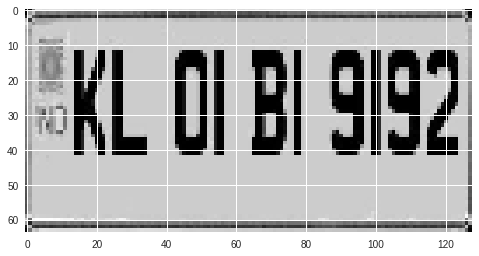

2) the_labels (plate number): KL01BI9192 is encoded as [20, 21, 0, 1, 11, 18, 9, 1, 9, 2]
3) input_length (width of image that is fed to the loss function): 30 == 128 / 4 - 2
4) label_length (length of plate number): 10


In [32]:
for inp, out in tiger.next_batch():
    print('Text generator output (data which will be fed into the neutral network):')
    print('1) the_input (image)')
    if K.image_data_format() == 'channels_first':
        img = inp['the_input'][0, 0, :, :]
    else:
        img = inp['the_input'][0, :, :, 0]
    
    plt.imshow(img.T, cmap='gray')
    plt.show()
    print('2) the_labels (plate number): %s is encoded as %s' % 
          (labels_to_text(inp['the_labels'][0]), list(map(int, inp['the_labels'][0]))))
    print('3) input_length (width of image that is fed to the loss function): %d == %d / 4 - 2' % 
          (inp['input_length'][0], tiger.img_w))
    print('4) label_length (length of plate number): %d' % inp['label_length'][0])
    break

In [0]:
def ctc_lambda_func(args):
    y_pred, labels, input_length, label_length = args
    y_pred = y_pred[:, 2:, :]
    return K.ctc_batch_cost(labels, y_pred, input_length, label_length)
def train(img_w, load=False):
    img_h = 64
    conv_filters = 16
    kernel_size = (3,3)
    pool_size = 2
    time_dense_size = 32
    rnn_size = 512
    if K.image_data_format() == 'channels_first':
        input_shape = (1, img_w, img_h)
    else:
        input_shape = (img_w, img_h, 1)
    batch_size = 32
    downsample_factor = pool_size ** 2
    tiger_train = TextImageGenerator('/content/data', 'train', img_w, img_h, batch_size, downsample_factor)
    tiger_train.build_data()
    tiger_val = TextImageGenerator('/content/data', 'val', img_w, img_h, batch_size, downsample_factor)
    tiger_val.build_data()
    act = 'relu'
    input_data = Input(name='the_input', shape=input_shape, dtype='float32')
    inner = Conv2D(conv_filters, kernel_size, padding='same',
                   activation=act, kernel_initializer='he_normal',
                   name='conv1')(input_data)
    inner = MaxPooling2D(pool_size=(pool_size, pool_size), name='max1')(inner)
    inner = Conv2D(conv_filters, kernel_size, padding='same',
                   activation=act, kernel_initializer='he_normal',
                   name='conv2')(inner)
    inner = MaxPooling2D(pool_size=(pool_size, pool_size), name='max2')(inner)
    conv_to_rnn_dims = (img_w // (pool_size ** 2), (img_h // (pool_size ** 2)) * conv_filters)
    inner = Reshape(target_shape=conv_to_rnn_dims, name='reshape')(inner)
    inner = Dense(time_dense_size, activation=act, name='dense1')(inner)
    gru_1 = GRU(rnn_size, return_sequences=True, kernel_initializer='he_normal', name='gru1')(inner)
    gru_1b = GRU(rnn_size, return_sequences=True, go_backwards=True, kernel_initializer='he_normal', name='gru1_b')(inner)
    gru1_merged = add([gru_1, gru_1b])
    gru_2 = GRU(rnn_size, return_sequences=True, kernel_initializer='he_normal', name='gru2')(gru1_merged)
    gru_2b = GRU(rnn_size, return_sequences=True, go_backwards=True, kernel_initializer='he_normal', name='gru2_b')(gru1_merged)
    inner = Dense(tiger_train.get_output_size(), kernel_initializer='he_normal',
                  name='dense2')(concatenate([gru_2, gru_2b]))
    y_pred = Activation('softmax', name='softmax')(inner)
    model = Model(inputs=input_data, outputs=y_pred).summary()
    labels = Input(name='the_labels', shape=[tiger_train.max_text_len], dtype='float32')
    input_length = Input(name='input_length', shape=[1], dtype='int64')
    label_length = Input(name='label_length', shape=[1], dtype='int64')
    loss_out = Lambda(ctc_lambda_func, output_shape=(1,), name='ctc')([y_pred, labels, input_length, label_length])
    sgd = SGD(lr=0.02, decay=1e-6, momentum=0.9, nesterov=True, clipnorm=5)
    if load:
        model = load_model('./tmp_model.h5', compile=False)
    else:
        model = Model(inputs=[input_data, labels, input_length, label_length], outputs=loss_out)
    model.compile(loss={'ctc': lambda y_true, y_pred: y_pred}, optimizer=sgd)
    if not load:
        model.fit_generator(generator=tiger_train.next_batch(), 
                            steps_per_epoch=tiger_train.n,
                            epochs=1, 
                            validation_data=tiger_val.next_batch(), 
                            validation_steps=tiger_val.n)
    return model

In [34]:
model = train(128, load=False)

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
the_input (InputLayer)          (None, 128, 64, 1)   0                                            
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 128, 64, 16)  160         the_input[0][0]                  
__________________________________________________________________________________________________
max1 (MaxPooling2D)             (None, 64, 32, 16)   0           conv1[0][0]                      
__________________________________________________________________________________________________
conv2 (Conv2D)                  (None, 64, 32, 16)   2320        max1[0][0]                       
__________________________________________________________________________________________________
max2 (MaxP

In [0]:
rm 'weights.h5'

In [0]:
model.save_weights('weights.h5')

In [51]:
img_w = 128
img_h = 64
conv_filters =16
kernel_size = (3,3)
pool_size = 2
time_dense_size = 32
rnn_size = 512
if K.image_data_format() == 'channels_first':
    input_shape = (1, img_w, img_h)
else:
    input_shape = (img_w, img_h, 1)
batch_size = 32
downsample_factor = pool_size ** 2
tiger_train = TextImageGenerator('/content/data', 'train', img_w, img_h, batch_size, downsample_factor)
tiger_train.build_data()
tiger_val = TextImageGenerator('/content/data', 'val', img_w, img_h, batch_size, downsample_factor)
tiger_val.build_data()
act = 'relu'
input_data = Input(name='the_input', shape=input_shape, dtype='float32')
inner = Conv2D(conv_filters, kernel_size, padding='same',
               activation=act, kernel_initializer='he_normal',
               name='conv1')(input_data)
inner = MaxPooling2D(pool_size=(pool_size, pool_size), name='max1')(inner)
inner = Conv2D(conv_filters, kernel_size, padding='same',
               activation=act, kernel_initializer='he_normal',
               name='conv2')(inner)
inner = MaxPooling2D(pool_size=(pool_size, pool_size), name='max2')(inner)

conv_to_rnn_dims = (img_w // (pool_size ** 2), (img_h // (pool_size ** 2)) * conv_filters)
inner = Reshape(target_shape=conv_to_rnn_dims, name='reshape')(inner)
inner = Dense(time_dense_size, activation=act, name='dense1')(inner)
gru_1 = GRU(rnn_size, return_sequences=True, kernel_initializer='he_normal', name='gru1')(inner)
gru_1b = GRU(rnn_size, return_sequences=True, go_backwards=True, kernel_initializer='he_normal', name='gru1_b')(inner)
gru1_merged = add([gru_1, gru_1b])
gru_2 = GRU(rnn_size, return_sequences=True, kernel_initializer='he_normal', name='gru2')(gru1_merged)
gru_2b = GRU(rnn_size, return_sequences=True, go_backwards=True, kernel_initializer='he_normal', name='gru2_b')(gru1_merged)
inner = Dense(tiger_train.get_output_size(), kernel_initializer='he_normal',
              name='dense2')(concatenate([gru_2, gru_2b]))
y_pred = Activation('softmax', name='softmax')(inner)
Model(inputs=input_data, outputs=y_pred).summary()

labels = Input(name='the_labels', shape=[tiger_train.max_text_len], dtype='float32')
input_length = Input(name='input_length', shape=[1], dtype='int64')
label_length = Input(name='label_length', shape=[1], dtype='int64')
loss_out = Lambda(ctc_lambda_func, output_shape=(1,), name='ctc')([y_pred, labels, input_length, label_length])
sgd = SGD(lr=0.02, decay=1e-6, momentum=0.9, nesterov=True, clipnorm=5)
#if load:
    #model = load_model('./tmp_model.h5', compile=False)
#else:
    #model = Model(inputs=[input_data, labels, input_length, label_length], outputs=loss_out)
model = Model(inputs=[input_data, labels, input_length, label_length], outputs=loss_out)
model.compile(loss={'ctc': lambda y_true, y_pred: y_pred}, optimizer=sgd)
model.load_weights('/content/data/weights.h5')

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
the_input (InputLayer)          (None, 128, 64, 1)   0                                            
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 128, 64, 16)  160         the_input[0][0]                  
__________________________________________________________________________________________________
max1 (MaxPooling2D)             (None, 64, 32, 16)   0           conv1[0][0]                      
__________________________________________________________________________________________________
conv2 (Conv2D)                  (None, 64, 32, 16)   2320        max1[0][0]                       
__________________________________________________________________________________________________
max2 (MaxP

In [0]:
model1=Model(inputs=input_data,outputs=y_pred)

In [26]:
os.getcwd()

'/content/data'

In [83]:
from google.colab import files
files.upload()

Saving NUMBER.jpg to NUMBER.jpg


{'NUMBER.jpg': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x01\x00x\x00x\x00\x00\xff\xe1\x00"Exif\x00\x00MM\x00*\x00\x00\x00\x08\x00\x01\x01\x12\x00\x03\x00\x00\x00\x01\x00\x01\x00\x00\x00\x00\x00\x00\xff\xfe\x00<CREATOR: gd-jpeg v1.0 (using IJG JPEG v62), quality = 90\n\x00\xff\xdb\x00C\x00\x02\x01\x01\x02\x01\x01\x02\x02\x02\x02\x02\x02\x02\x02\x03\x05\x03\x03\x03\x03\x03\x06\x04\x04\x03\x05\x07\x06\x07\x07\x07\x06\x07\x07\x08\t\x0b\t\x08\x08\n\x08\x07\x07\n\r\n\n\x0b\x0c\x0c\x0c\x0c\x07\t\x0e\x0f\r\x0c\x0e\x0b\x0c\x0c\x0c\xff\xdb\x00C\x01\x02\x02\x02\x03\x03\x03\x06\x03\x03\x06\x0c\x08\x07\x08\x0c\x0c\x0c\x0c\x0c\x0c\x0c\x0c\x0c\x0c\x0c\x0c\x0c\x0c\x0c\x0c\x0c\x0c\x0c\x0c\x0c\x0c\x0c\x0c\x0c\x0c\x0c\x0c\x0c\x0c\x0c\x0c\x0c\x0c\x0c\x0c\x0c\x0c\x0c\x0c\x0c\x0c\x0c\x0c\x0c\x0c\x0c\x0c\x0c\x0c\xff\xc0\x00\x11\x08\x00<\x00\xe0\x03\x01"\x00\x02\x11\x01\x03\x11\x01\xff\xc4\x00\x1f\x00\x00\x01\x05\x01\x01\x01\x01\x01\x01\x00\x00\x00\x00\x00\x00\x00\x00\x01\x02\x03\x04\x05\x06\x07\x08\t\n\x0b

In [0]:
ls

In [130]:
from keras.models import load_model
model2=load_model('model1_better.h5')

/usr/local/lib/python3.6/dist-packages/keras/models.py:282: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


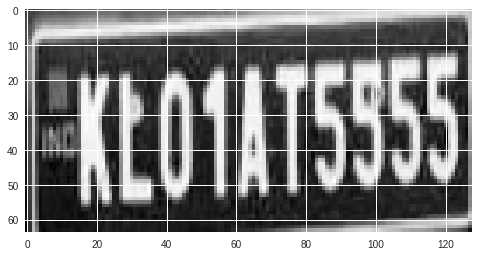

In [58]:
image=cv2.imread('dc-Cover-174a6v8o8jqrkrtp73nsiuhhh5-20161207065801.Medi.jpeg')
image=cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)
image=cv2.resize(image,(128, 64))
plt.imshow(image)
image=image.T
image=image.astype(np.float32)
image=image/255
image=np.expand_dims(image,-1)
image=np.expand_dims(image,0)

In [0]:
def decode_batch(out):
    ret = []
    for j in range(out.shape[0]):
        out_best = list(np.argmax(out[j, 2:], 1))
        out_best = [k for k, g in itertools.groupby(out_best)]
        outstr = ''
        for c in out_best:
            if c < len(letters):
                outstr += letters[c]
        ret.append(outstr)
    return ret

In [0]:
model.save('model01.h5')

In [60]:
out=model1.predict(image)
decode_batch(out)

['KL0114']